# Lending Club Case Study

### Objective of the case study is to identify risky loan applicants. Risky loan applicants of are the borrowers who refuse to pay. They are labelled as Charged-Off and are the defaulters. 
### Aim of the study is to indentify the factors which may cause the loan applicants to default.

### Import the loan dataset

In [103]:
# import libs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)


# load dataset
loan_df = pd.read_csv("loan.csv", low_memory=False);

### Inspect dataset

In [104]:

print(loan_df.info(verbose=1));
print(loan_df.head());

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 111 columns):
 #    Column                          Dtype  
---   ------                          -----  
 0    id                              int64  
 1    member_id                       int64  
 2    loan_amnt                       int64  
 3    funded_amnt                     int64  
 4    funded_amnt_inv                 float64
 5    term                            object 
 6    int_rate                        object 
 7    installment                     float64
 8    grade                           object 
 9    sub_grade                       object 
 10   emp_title                       object 
 11   emp_length                      object 
 12   home_ownership                  object 
 13   annual_inc                      float64
 14   verification_status             object 
 15   issue_d                         object 
 16   loan_status                     object 
 17   pymnt_plan

### find the percentage of NA values in each column


In [105]:
missing_vals = (loan_df.isna().mean()*100).sort_values(ascending=False);
print(missing_vals);

num_il_tl                         100.000000
num_bc_sats                       100.000000
num_bc_tl                         100.000000
num_actv_bc_tl                    100.000000
num_accts_ever_120_pd             100.000000
mths_since_recent_revol_delinq    100.000000
num_actv_rev_tl                   100.000000
mths_since_recent_inq             100.000000
num_tl_90g_dpd_24m                100.000000
num_tl_30dpd                      100.000000
num_tl_120dpd_2m                  100.000000
num_sats                          100.000000
num_rev_tl_bal_gt_0               100.000000
num_rev_accts                     100.000000
pct_tl_nvr_dlq                    100.000000
mo_sin_old_il_acct                100.000000
mo_sin_old_rev_tl_op              100.000000
mo_sin_rcnt_rev_tl_op             100.000000
mo_sin_rcnt_tl                    100.000000
mths_since_recent_bc              100.000000
mort_acc                          100.000000
mths_since_recent_bc_dlq          100.000000
bc_util   

### remove columns with > 30% missing data

In [106]:
loan_df = loan_df.loc[:, missing_vals < 30]


### On a quick inspection of the CSV, it was observed that few columns had only zeroes. Checking if indeed it was the case

In [107]:
cols_with_zero_vals = loan_df.columns[loan_df.any() == False]
print(cols_with_zero_vals)

Index(['collections_12_mths_ex_med', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens'], dtype='object')


### Remove the columns with only zeroes and check the shape


In [108]:
loan_df.drop(cols_with_zero_vals, axis=1, inplace=True)


In [109]:
# inspect data 
print(loan_df.describe())
print(loan_df.info(verbose=1))

                 id     member_id     loan_amnt   funded_amnt  funded_amnt_inv   installment    annual_inc           dti   delinq_2yrs  inq_last_6mths      open_acc       pub_rec      revol_bal     total_acc     out_prncp  out_prncp_inv   total_pymnt  total_pymnt_inv  total_rec_prncp  total_rec_int  total_rec_late_fee    recoveries  collection_recovery_fee  last_pymnt_amnt  policy_code  pub_rec_bankruptcies
count  3.971700e+04  3.971700e+04  39717.000000  39717.000000     39717.000000  39717.000000  3.971700e+04  39717.000000  39717.000000    39717.000000  39717.000000  39717.000000   39717.000000  39717.000000  39717.000000   39717.000000  39717.000000     39717.000000     39717.000000   39717.000000        39717.000000  39717.000000             39717.000000     39717.000000      39717.0          39020.000000
mean   6.831319e+05  8.504636e+05  11219.443815  10947.713196     10397.448868    324.561922  6.896893e+04     13.315130      0.146512        0.869200      9.294408      0.055065

### For analysis, we need to analyse the data points applicable during loan application. Which are below:
<ol>
    <li>loan_amnt amount listed by the burrower. A very high amount may 'risky' </li>
    <li>funded_amnt</li>
    <li>funded_amnt_inv: Amount committed to a loan may be a driving factor</li>
    <li>term: No of payments on the loan</li>
    <li>int_rate: loan interest</li>
    <li>installment: the monthly payment</li>
    <li>grade</li>
    <li>sub_grade: assigning a quality score to a loan based on a borrower's credit history</li>
    <li>emp_length: Employment length in years.</li>
    <li>home_ownership: applicant's home ownership status</li>
    <li>annual_inc: annual income provided by the borrower</li>
    <li>verification_status: if income verified by LC</li>
    <li>loan_status: loan's current status</li>
    <li>pymnt_plan: loan's payment plan</li>
    <li>purpose: category provided by the borrower for the loan request. </li>
    <li>title: The loan title provided by the borrower</li>
    <li>dti: monthly debt payments to  monthly income ratio</li>
    <li>earliest_cr_line: when customer's first credit line was opened</li>
    <li>inq_last_6mths: inquiries in last six months</li>
    <li>open_acc: no of open credit lines</li>
    <li>pub_rec: no of public derogatory records</li>
    <li>total_acc:  total number of credit lines currently in the borrower's credit file</li>
    <li>pub_rec_bankruptcies: Number of public record bankruptcies</li>
    <li>issue_d: Loan issue date</li>
<ol>

In [110]:
cols_to_keep = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade' , 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 'pymnt_plan', 'purpose', 'title', 'dti', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc', 'pub_rec_bankruptcies', 'issue_d']
loan_df = loan_df.loc[:, cols_to_keep]
print(loan_df.shape)

(39717, 25)


### NA values after removing columns with > 30% missing values in clean dataset

In [111]:
missing_vals = (loan_df.isna().mean()*100).sort_values(ascending=False);
print(missing_vals);

emp_length              2.706650
pub_rec_bankruptcies    1.754916
title                   0.027696
loan_amnt               0.000000
funded_amnt             0.000000
int_rate                0.000000
installment             0.000000
term                    0.000000
funded_amnt_inv         0.000000
sub_grade               0.000000
grade                   0.000000
verification_status     0.000000
home_ownership          0.000000
loan_status             0.000000
pymnt_plan              0.000000
purpose                 0.000000
annual_inc              0.000000
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
inq_last_6mths          0.000000
pub_rec                 0.000000
total_acc               0.000000
issue_d                 0.000000
application_type        0.000000
dtype: float64


### handle missing values

In [112]:
# in emp_length column
loan_df['emp_length'] = loan_df['emp_length'].fillna(loan_df['emp_length'].mode()[0])

# pub_rec_bankruptcies
loan_df['pub_rec_bankruptcies'] = loan_df['pub_rec_bankruptcies'].fillna(loan_df['pub_rec_bankruptcies'].median())

# title
loan_df['title'] = loan_df['title'].fillna(loan_df['title'].mode()[0])


### select columns with datatype = object and inspect their sample data

In [113]:
obj_cols = loan_df.select_dtypes(include=["object"]).columns;

for ocol in obj_cols:
    print('---------------------------------------------------------------------------------------------------------\n');
    print('sample data in column ', ocol , '\n');
    print(loan_df[ocol].head(n=10));



---------------------------------------------------------------------------------------------------------

sample data in column  term 

0     36 months
1     60 months
2     36 months
3     36 months
4     60 months
5     36 months
6     60 months
7     36 months
8     60 months
9     60 months
Name: term, dtype: object
---------------------------------------------------------------------------------------------------------

sample data in column  int_rate 

0    10.65%
1    15.27%
2    15.96%
3    13.49%
4    12.69%
5     7.90%
6    15.96%
7    18.64%
8    21.28%
9    12.69%
Name: int_rate, dtype: object
---------------------------------------------------------------------------------------------------------

sample data in column  grade 

0    B
1    C
2    C
3    C
4    B
5    A
6    C
7    E
8    F
9    B
Name: grade, dtype: object
---------------------------------------------------------------------------------------------------------

sample data in column  sub_grade 

0    B2
1

### convert datatypes

In [114]:
import re
#term column
loan_df['term'] = loan_df['term'].apply(lambda x : re.findall(r'\d+', x)[0]).astype('int64');



In [115]:
#int_rate olumn
loan_df['int_rate'] = loan_df['int_rate'].apply(lambda x : str(x).replace('%', '')).astype('float64');



In [116]:
#emp_length column
#Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
#Needs data correction
loan_df['emp_length'] = loan_df['emp_length'].apply(lambda x : str(x).replace('< 1 year', '0').replace('10+ years', '10').replace('years', '').replace('year', '').strip()).astype('int64')
print(loan_df['emp_length'].value_counts());


emp_length
10    9954
0     4583
2     4388
3     4095
4     3436
5     3282
1     3240
6     2229
7     1773
8     1479
9     1258
Name: count, dtype: int64


In [117]:
import datetime
loan_df['issue_d_month'] = loan_df['issue_d'].apply(lambda x : datetime.datetime.strptime(str(x).replace('-', ' 20'),'%b %Y').strftime('%m')).astype('int64')
loan_df['issue_d_year'] = loan_df['issue_d'].apply(lambda x : datetime.datetime.strptime(str(x).replace('-', ' 20'),'%b %Y').strftime('%Y')).astype('int64')

### check the missing values again

In [118]:
print(loan_df.isna().mean() * 100);

loan_amnt               0.0
funded_amnt             0.0
funded_amnt_inv         0.0
term                    0.0
int_rate                0.0
installment             0.0
grade                   0.0
sub_grade               0.0
emp_length              0.0
home_ownership          0.0
annual_inc              0.0
verification_status     0.0
loan_status             0.0
pymnt_plan              0.0
purpose                 0.0
title                   0.0
dti                     0.0
earliest_cr_line        0.0
inq_last_6mths          0.0
open_acc                0.0
pub_rec                 0.0
total_acc               0.0
pub_rec_bankruptcies    0.0
issue_d                 0.0
application_type        0.0
issue_d_month           0.0
issue_d_year            0.0
dtype: float64


### check the datatypes again

In [119]:
print(loan_df.dtypes)

loan_amnt                 int64
funded_amnt               int64
funded_amnt_inv         float64
term                      int64
int_rate                float64
installment             float64
grade                    object
sub_grade                object
emp_length                int64
home_ownership           object
annual_inc              float64
verification_status      object
loan_status              object
pymnt_plan               object
purpose                  object
title                    object
dti                     float64
earliest_cr_line         object
inq_last_6mths            int64
open_acc                  int64
pub_rec                   int64
total_acc                 int64
pub_rec_bankruptcies    float64
issue_d                  object
application_type         object
issue_d_month             int64
issue_d_year              int64
dtype: object


In [120]:
print(loan_df.info(verbose=1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             39717 non-null  int64  
 1   funded_amnt           39717 non-null  int64  
 2   funded_amnt_inv       39717 non-null  float64
 3   term                  39717 non-null  int64  
 4   int_rate              39717 non-null  float64
 5   installment           39717 non-null  float64
 6   grade                 39717 non-null  object 
 7   sub_grade             39717 non-null  object 
 8   emp_length            39717 non-null  int64  
 9   home_ownership        39717 non-null  object 
 10  annual_inc            39717 non-null  float64
 11  verification_status   39717 non-null  object 
 12  loan_status           39717 non-null  object 
 13  pymnt_plan            39717 non-null  object 
 14  purpose               39717 non-null  object 
 15  title              

### Finding outliers

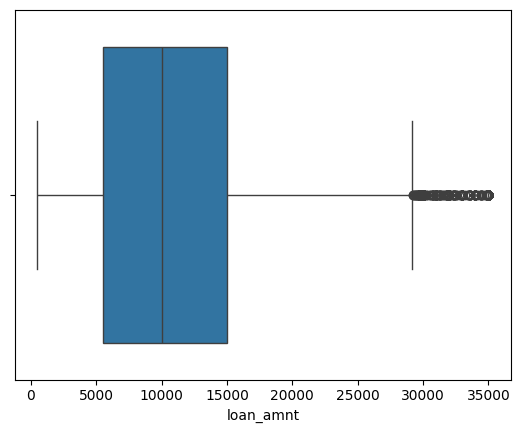

In [121]:
sns.boxplot(loan_df, x = 'loan_amnt')
plt.show()

In [122]:
print(loan_df['loan_amnt'].describe())

count    39717.000000
mean     11219.443815
std       7456.670694
min        500.000000
25%       5500.000000
50%      10000.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64


### Not a huge value jump from 75th percentile to the max value. keeping as-is

In [123]:
loan_amnt_quantiles = loan_df['loan_amnt'].quantile([0.90, 0.97, 1])
print(loan_amnt_quantiles)

0.90    22000.0
0.97    30000.0
1.00    35000.0
Name: loan_amnt, dtype: float64


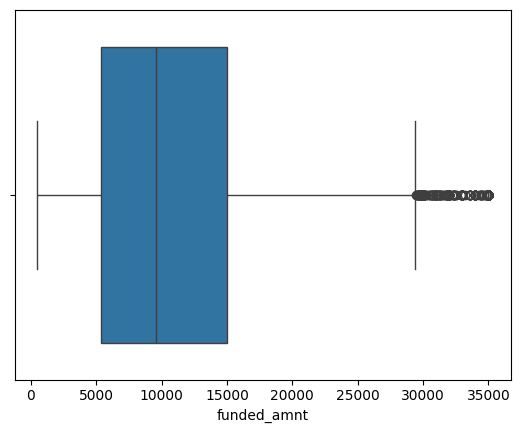

In [124]:
#funded_amnt
sns.boxplot(loan_df, x='funded_amnt')
plt.show()

In [125]:
print(loan_df['funded_amnt'].describe())

count    39717.000000
mean     10947.713196
std       7187.238670
min        500.000000
25%       5400.000000
50%       9600.000000
75%      15000.000000
max      35000.000000
Name: funded_amnt, dtype: float64


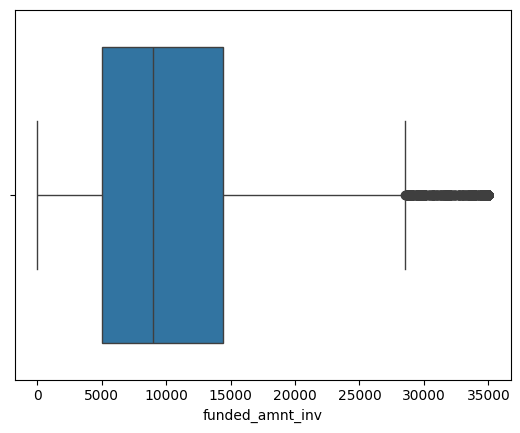

count    39717.000000
mean     10397.448868
std       7128.450439
min          0.000000
25%       5000.000000
50%       8975.000000
75%      14400.000000
max      35000.000000
Name: funded_amnt_inv, dtype: float64


In [126]:
sns.boxplot(loan_df, x='funded_amnt_inv')
plt.show()
print(loan_df['funded_amnt_inv'].describe())

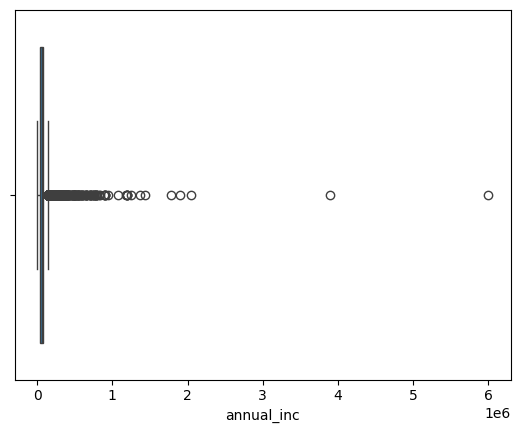

count    3.971700e+04
mean     6.896893e+04
std      6.379377e+04
min      4.000000e+03
25%      4.040400e+04
50%      5.900000e+04
75%      8.230000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64


In [127]:
sns.boxplot(loan_df, x='annual_inc')
plt.show()
print(loan_df['annual_inc'].describe())

### annual income distribution is not continuous in nature beyond 1000000 mark. Needs further analysis

In [128]:
annual_inc_quantiles = loan_df['annual_inc'].quantile([0.50, 0.75, 0.90, 0.95, 0.98, 0.99 , 1])
print(annual_inc_quantiles)

0.50      59000.00
0.75      82300.00
0.90     116000.00
0.95     142000.00
0.98     187000.00
0.99     234999.36
1.00    6000000.00
Name: annual_inc, dtype: float64


### Huge jump after the 95th Percentile. So keeping data till 95th percentile only

In [129]:
loan_df = loan_df[loan_df['annual_inc'] <= loan_df['annual_inc'].quantile(0.95)]


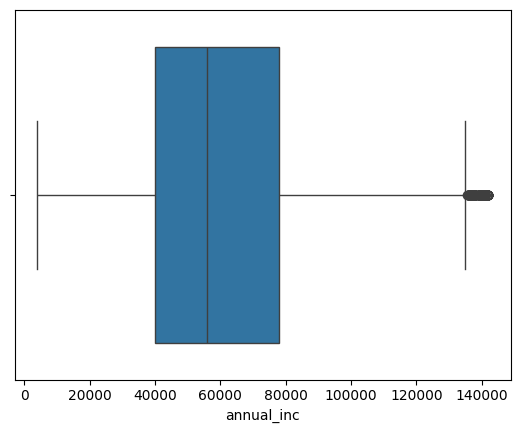

In [130]:
sns.boxplot(loan_df, x='annual_inc')
plt.show()

### Save the cleaned dataset to csv file


In [131]:
loan_df.to_csv("loan_cleaned_dataset.csv", index=False)

## Univariate Analysis


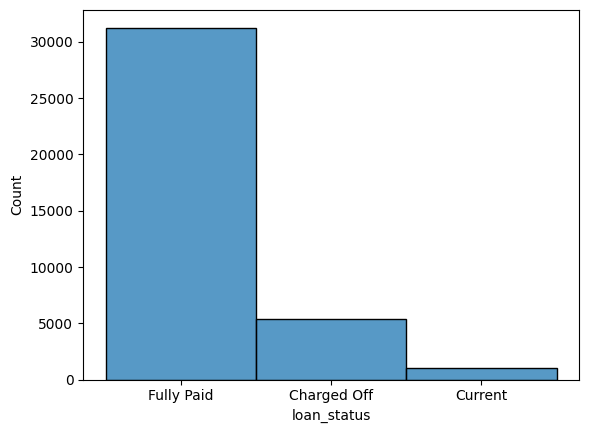

In [132]:
sns.histplot(loan_df, x='loan_status')
plt.show()

### Out of the 3 categrories in the above that, we are only considering the charged-off cases for univariate analysis to determine which variable may cause a loan to default

In [133]:
charged_off = loan_df[loan_df['loan_status'] == 'Charged Off' ]

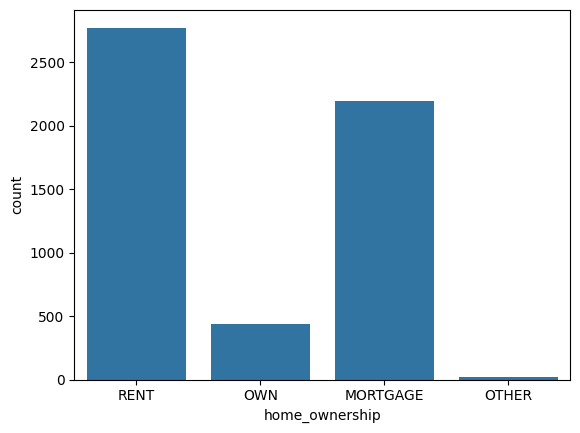

In [134]:
sns.countplot(x ='home_ownership', data = charged_off)
plt.show()

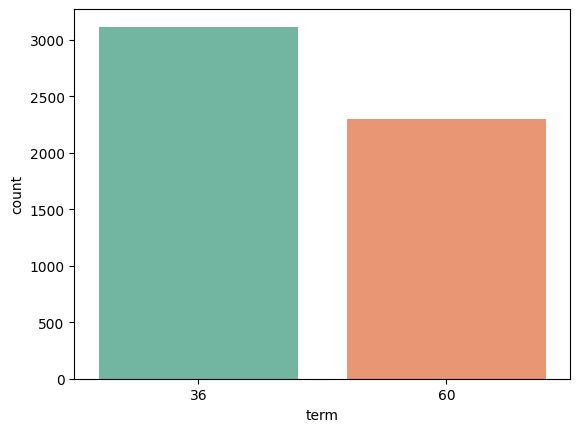

In [135]:
sns.countplot(x ='term', data = charged_off, palette = "Set2")
plt.show()

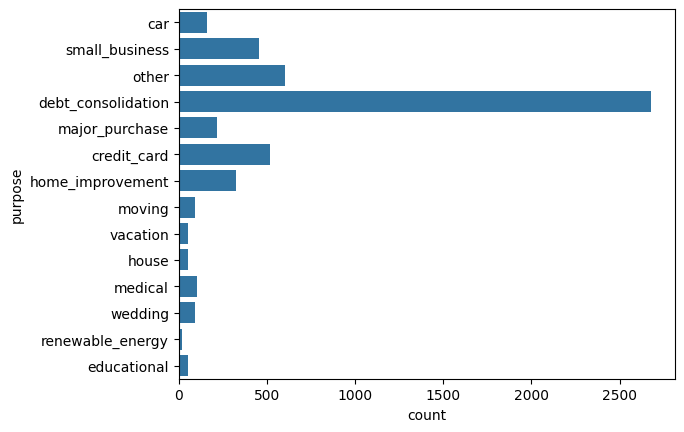

In [136]:
sns.countplot(y ='purpose', data = charged_off )
plt.show()

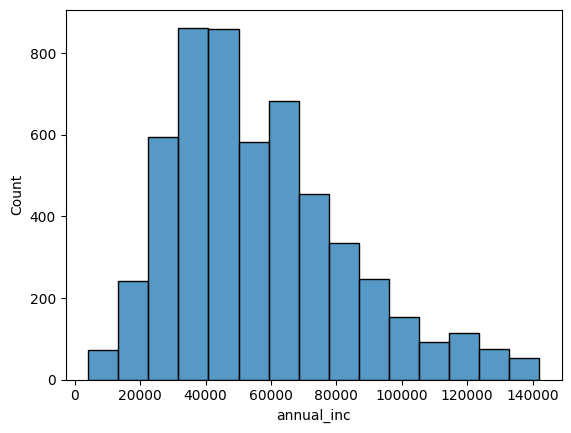

In [137]:
sns.histplot(charged_off, x = 'annual_inc', bins=15);




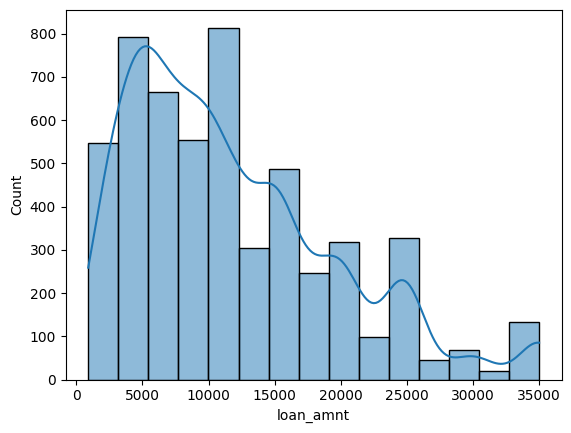

In [138]:
sns.histplot(charged_off, x = 'loan_amnt', bins=15, kde=True) 
plt.show()

### int_rate analysis

### dti analysis

### emp_length

grade
B    1378
C    1325
D    1081
E     660
A     593
F     289
G      95
Name: count, dtype: int64


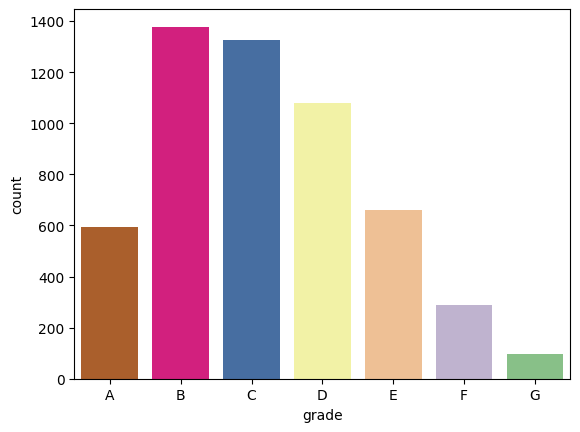

In [139]:
print(charged_off['grade'].value_counts())

sns.countplot(charged_off, x = 'grade', order=['A', 'B', 'C', 'D', 'E', 'F', 'G'], palette='Accent_r') 
plt.show()

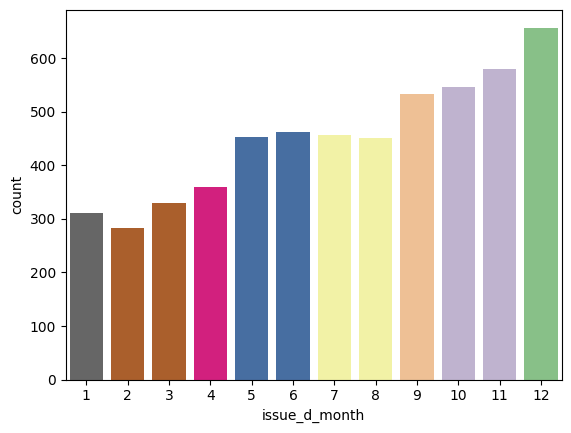

In [140]:

sns.countplot(charged_off, x = 'issue_d_month', palette='Accent_r') 
plt.show()